In [83]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
import random
import os
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn import preprocessing
from sklearn.metrics import log_loss
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import warnings
warnings.filterwarnings('ignore')

In [3]:
df_names = ['train_features', 'train_targets_scored', 'train_targets_nonscored', 'test_features', 'sample_submission']

df = {}
for name in df_names:
    df[name] = pd.read_csv(f"{name}.csv", index_col=0)
    print(f"{name}: {df[name].shape}")

train_features: (23814, 875)
train_targets_scored: (23814, 206)
train_targets_nonscored: (23814, 402)
test_features: (3982, 875)
sample_submission: (3982, 206)


In [4]:
df_full = pd.concat([df['train_features'], df['train_targets_scored'].add_prefix('scored_'), df['train_targets_nonscored'].add_prefix('nonscored_')], axis=1)
df_full['count_scored'] = df_full.filter(regex='^scored_').sum(axis=1)
df_full['count_nonscored'] = df_full.filter(regex='^nonscored_').sum(axis=1)
df_full['count_total'] = df_full['count_scored'] + df_full['count_nonscored']
df_full.iloc[:3,-4:]

nonscored_xiap_inhibitor  count_scored  count_nonscored  \
sig_id                                                                  
id_000644bb2                         0             1                0   
id_000779bfc                         0             0                0   
id_000a6266a                         0             3                0   

              count_total  
sig_id                     
id_000644bb2            1  
id_000779bfc            0  
id_000a6266a            3

In [5]:
cols = list(df_full.filter(regex='^(scored|nonscored)_').columns)
df_target_combine = df_full[cols].groupby(cols).size().reset_index(name='Combination_Count').sort_values('Combination_Count', ascending=False).reset_index(drop=True)

In [6]:
df_target_combine['Combination_Label'] = df_target_combine.index
df_target_combine = df_target_combine[['Combination_Label', 'Combination_Count'] + cols]
df_target_combine.head()

Combination_Label  Combination_Count  scored_5-alpha_reductase_inhibitor  \
0                  0               5530                                   0   
1                  1                718                                   0   
2                  2                363                                   0   
3                  3                337                                   0   
4                  4                328                                   0   

   scored_11-beta-hsd1_inhibitor  scored_acat_inhibitor  \
0                              0                      0   
1                              0                      0   
2                              0                      0   
3                              0                      0   
4                              0                      0   

   scored_acetylcholine_receptor_agonist  \
0                                      0   
1                                      0   
2                                      0   
3                                      0   
4                                      0   

   scored_acetylcholine_receptor_antagonist  \
0                                         0   
1                                         0   
2                                         0   
3                                         0   
4                                         0   

   scored_acetylcholinesterase_inhibitor  scored_adenosine_receptor_agonist  \
0                                      0                                  0   
1                                      0                                  0   
2                                      0                                  0   
3                                      0                                  0   
4                                      0                                  0   

   scored_adenosine_receptor_antagonist  scored_adenylyl_cyclase_activator  \
0                                     0                                  0   
1                                     0                                  0   
2                                     0                                  0   
3                                     0                                  0   
4                                     0                                  0   

   scored_adrenergic_receptor_agonist  scored_adrenergic_receptor_antagonist  \
0                                   0                                      0   
1                                   0                                      0   
2                                   0                                      0   
3                                   0                                      0   
4                                   0                                      1   

   scored_akt_inhibitor  scored_aldehyde_dehydrogenase_inhibitor  \
0                     0                                        0   
1                     0                                        0   
2                     0                                        0   
3                     0                                        0   
4                     0                                        0   

   scored_alk_inhibitor  scored_ampk_activator  scored_analgesic  \
0                     0                      0                 0   
1                     0                      0                 0   
2                     0                      0                 0   
3                     0                      0                 0   
4                     0                      0                 0   

   scored_androgen_receptor_agonist  scored_androgen_receptor_antagonist  \
0                                 0                                    0   
1                                 0                                    0   
2                                 0                                    0   
3                                 0                                    0   
4 

In [7]:
df_target_combine.shape

(696, 610)

In [8]:
transition = df_target_combine[['Combination_Label']+cols].set_index('Combination_Label')

In [9]:
transition.head()

scored_5-alpha_reductase_inhibitor  \
Combination_Label                                       
0                                                   0   
1                                                   0   
2                                                   0   
3                                                   0   
4                                                   0   

                   scored_11-beta-hsd1_inhibitor  scored_acat_inhibitor  \
Combination_Label                                                         
0                                              0                      0   
1                                              0                      0   
2                                              0                      0   
3                                              0                      0   
4                                              0                      0   

                   scored_acetylcholine_receptor_agonist  \
Combination_Label                                          
0                                                      0   
1                                                      0   
2                                                      0   
3                                                      0   
4                                                      0   

                   scored_acetylcholine_receptor_antagonist  \
Combination_Label                                             
0                                                         0   
1                                                         0   
2                                                         0   
3                                                         0   
4                                                         0   

                   scored_acetylcholinesterase_inhibitor  \
Combination_Label                                          
0                                                      0   
1                                                      0   
2                                                      0   
3                                                      0   
4                                                      0   

                   scored_adenosine_receptor_agonist  \
Combination_Label                                      
0                                                  0   
1                                                  0   
2                                                  0   
3                                                  0   
4                                                  0   

                   scored_adenosine_receptor_antagonist  \
Combination_Label                                         
0                                                     0   
1                                                     0   
2                                                     0   
3                                                     0   
4                                                     0   

                   scored_adenylyl_cyclase_activator  \
Combination_Label                                      
0                                                  0   
1                                                  0   
2                                                  0   
3                                                  0   
4                                                  0   

                   scored_adrenergic_receptor_agonist  \
Combination_Label                                       
0                                                   0   
1                                                   0   
2                                                   0   
3                                                   0   
4                                                   0   

                   scored_adrenergic_receptor_antagonist  \
Combination_Label                                          
0                                                      0   
1                            

In [14]:
transition.shape

(696, 608)

In [10]:
df_full_combine = pd.merge(df_full, df_target_combine, on=cols, how='left').drop(columns=cols)

In [11]:
df_full_combine.head()

cp_type  cp_time cp_dose     g-0     g-1     g-2     g-3     g-4     g-5  \
0  trt_cp       24      D1  1.0620  0.5577 -0.2479 -0.6208 -0.1944 -1.0120   
1  trt_cp       72      D1  0.0743  0.4087  0.2991  0.0604  1.0190  0.5207   
2  trt_cp       48      D1  0.6280  0.5817  1.5540 -0.0764 -0.0323  1.2390   
3  trt_cp       48      D1 -0.5138 -0.2491 -0.2656  0.5288  4.0620 -0.8095   
4  trt_cp       72      D2 -0.3254 -0.4009  0.9700  0.6919  1.4180 -0.8244   

      g-6     g-7     g-8     g-9    g-10    g-11    g-12    g-13    g-14  \
0 -1.0220 -0.0326  0.5548 -0.0921  1.1830  0.1530  0.5574 -0.4015  0.1789   
1  0.2341  0.3372 -0.4047  0.8507 -1.1520 -0.4201 -0.0958  0.4590  0.0803   
2  0.1715  0.2155  0.0065  1.2300 -0.4797 -0.5631 -0.0366 -1.8300  0.6057   
3 -1.9590  0.1792 -0.1321 -1.0600 -0.8269 -0.3584 -0.8511 -0.5844 -2.5690   
4 -0.2800 -0.1498 -0.8789  0.8630 -0.2219 -0.5121 -0.9577  1.1750  0.2042   

     g-15    g-16    g-17    g-18    g-19    g-20    g-21    g-22    g-23  \
0 -0.6528 -0.7969  0.6342  0.1778 -0.3694 -0.5688 -1.1360 -1.1880  0.6940   
1  0.2250  0.5293  0.2839 -0.3494  0.2883  0.9449 -0.1646 -0.2657 -0.3372   
2 -0.3278  0.6042 -0.3075 -0.1147 -0.0570 -0.0799 -0.8181 -1.5320  0.2307   
3  0.8183 -0.0532 -0.8554  0.1160 -2.3520  2.1200 -1.1580 -0.7191 -0.8004   
4  0.1970  0.1244 -1.7090 -0.3543 -0.5160 -0.3330 -0.2685  0.7649  0.2057   

     g-24    g-25    g-26    g-27    g-28    g-29    g-30    g-31    g-32  \
0  0.4393  0.2664  0.1907  0.1628 -0.2853  0.5819  0.2934 -0.5584 -0.0916   
1  0.3135 -0.4316  0.4773  0.2075 -0.4216 -0.1161 -0.0499 -0.2627  0.9959   
2  0.4901  0.4780 -1.3970  4.6240 -0.0437  1.2870 -1.8530  0.6069  0.4290   
3 -1.4670 -0.0107 -0.8995  0.2406 -0.2479 -1.0890 -0.7575  0.0881 -2.7370   
4  1.3720  0.6835  0.8056 -0.3754 -1.2090  0.2965 -0.0712  0.6389  0.6674   

     g-33    g-34    g-35    g-36    g-37    g-38    g-39    g-40    g-41  \
0 -0.3010 -0.1537  0.2198  0.2965 -0.5055 -0.5119 -0.2162 -0.0347 -0.2566   
1 -0.2483  0.2655 -0.2102  0.1656  0.5300 -0.2568 -0.0455  0.1194 -0.3958   
2  0.1783  0.0018 -1.1800  0.1256 -0.1219  5.4470  1.0310  0.3477 -0.5561   
3  0.8745  0.5787 -1.6740 -1.6720 -1.2690  3.0900 -0.3814 -0.7229 -0.0010   
4 -0.0783  1.1740 -0.7110 -1.4470  1.0620  0.7888 -0.0848  0.1302  0.1224   

     g-42    g-43    g-44    g-45    g-46    g-47    g-48    g-49    g-50  \
0 -1.1980  0.3116 -1.0330  0.2208 -0.1143 -0.0251  0.0350  0.4233 -0.1221   
1 -1.1730  0.4509  1.9250  1.1010  0.2648 -0.3615  0.1710 -0.8900  1.2730   
2  0.0357 -0.3636 -0.4653 -0.8346  0.1113 -0.7615 -0.4983  0.4552 -0.0978   
3  0.1353 -1.6400 -0.7483 -1.0820 -0.1521  0.0747 -0.4851  0.6636 -2.8230   
4  0.9584  0.2126  0.6162  1.1570  1.1140 -0.9416 -0.3780 -0.8147 -0.0803   

     g-51    g-52    g-53    g-54    g-55    g-56    g-57    g-58    g-59  \
0 -0.4927  0.6119  0.4715 -0.0351 -0.1605 -0.6750  0.2263  0.5790  0.9588   
1 -0.5036 -0.2277 -0.7339 -0.4283 -0.1231 -0.6328  0.4759  0.3249 -0.7408   
2 -0.2661  0.6058  0.2686 -0.6191 -0.4444  1.2540  0.0621 -0.1757 -1.4370   
3 -0.6035 -1.3550  2.0200 -0.5301 -1.3240 -0.5936  0.4331  0.0899 -1.5240   
4 -0.3818  0.6877  0.0000  0.1776  1.1320 -0.1180  1.2130  0.7709  0.6745   

     g-60    g-61    g-62    g-63    g-64    g-65    g-66    g-67    g-68  \
0  0.6061 -0.1300  0.6611 -0.3136 -0.2020  0.0251  0.1670 -0.4195  0.6551   
1 -0.5814  1.7840 -0.1087  1.0350  0.4087 -0.6948 -0.8026  0.0954 -0.4054   
2  0.5553  0.8346 -0.3334 -0.2933 -0.1644 -1.1280 -0.0292  0.0939  0.5916   
3  0.3936  1.4630 -1.2100 -1.2340 -1.0300  0.7977  0.2314  0.1186  1.5370   
4  0.7871  1.6410  0.1806  1.3480  1.1070  0.5392  0.0000  0.1255 -0.1556   

     g-69    g-70    g-71    g-72    g-73    g-74    g-75    g-76    g-77  \
0 -0.7395 -0.7047 -0.5369  0.0314 -0.5239 -0.3406 -0.6332 -1.0330 -0.3763   
1  0.1197  0.1956  0.0720 -0.2463 -0.1084  0.4008 -0.5857  0.8933  0.2842   
2  0.6809  0.7821  0.6801  0.9634  0.4057 -0.0708 -1.3570  0.

In [51]:
df_full_combine[df_full_combine['count_total'] == 0].head()

cp_type  cp_time cp_dose     g-0     g-1     g-2     g-3     g-4  \
1        trt_cp       72      D1  0.0743  0.4087  0.2991  0.0604  1.0190   
3        trt_cp       48      D1 -0.5138 -0.2491 -0.2656  0.5288  4.0620   
8        trt_cp       48      D1 -0.3014  0.5545 -0.2576 -0.1390 -0.6487   
25  ctl_vehicle       48      D1 -0.6696 -0.2718 -1.2230 -0.6226 -0.7220   
30       trt_cp       72      D1 -0.0722  0.5334 -0.3034  0.2864  0.1788   

       g-5     g-6     g-7     g-8     g-9    g-10    g-11    g-12    g-13  \
1   0.5207  0.2341  0.3372 -0.4047  0.8507 -1.1520 -0.4201 -0.0958  0.4590   
3  -0.8095 -1.9590  0.1792 -0.1321 -1.0600 -0.8269 -0.3584 -0.8511 -0.5844   
8  -0.6057 -0.7549  0.0896 -0.0946  1.3950  0.5803  0.0350  0.3887  0.8024   
25  0.1588  0.7785  0.7062 -0.7951  1.3770  0.2856 -0.8331  0.3879  1.3290   
30 -0.2903 -1.0640  0.4018 -0.0052  0.6192  0.4692 -0.2431 -0.3317 -1.4630   

      g-14    g-15    g-16    g-17    g-18    g-19    g-20    g-21    g-22  \
1   0.0803  0.2250  0.5293  0.2839 -0.3494  0.2883  0.9449 -0.1646 -0.2657   
3  -2.5690  0.8183 -0.0532 -0.8554  0.1160 -2.3520  2.1200 -1.1580 -0.7191   
8  -1.2810  0.4403 -0.5125  0.4421  0.0573 -0.3632 -0.7767  0.4234 -0.4403   
25 -0.4746  0.0857 -0.2745 -0.1093  0.2603  0.7386 -0.6665 -1.6520 -0.9262   
30  0.0243  0.8335  1.0290 -1.2610 -0.0644 -0.5713 -0.2902  0.4359 -0.2686   

      g-23    g-24    g-25    g-26    g-27    g-28    g-29    g-30    g-31  \
1  -0.3372  0.3135 -0.4316  0.4773  0.2075 -0.4216 -0.1161 -0.0499 -0.2627   
3  -0.8004 -1.4670 -0.0107 -0.8995  0.2406 -0.2479 -1.0890 -0.7575  0.0881   
8   0.0000 -0.7262 -0.3586  0.6236  0.7060 -0.3461 -0.8389  0.4151 -0.6344   
25  0.0000  1.6310 -0.2933  0.2043 -2.2070  0.1383 -0.4966  0.6922 -0.4077   
30 -0.6694  1.1930  0.4999  0.8176  0.5925 -0.4233  0.0024  0.0541 -0.5430   

      g-32    g-33    g-34    g-35    g-36    g-37    g-38    g-39    g-40  \
1   0.9959 -0.2483  0.2655 -0.2102  0.1656  0.5300 -0.2568 -0.0455  0.1194   
3  -2.7370  0.8745  0.5787 -1.6740 -1.6720 -1.2690  3.0900 -0.3814 -0.7229   
8  -0.3171 -0.3250 -0.9373 -0.0313 -0.2599 -0.4826  0.2074 -0.2445  0.1081   
25  0.2303 -0.0456 -0.7447 -0.7060 -0.8653  0.0799 -0.6794 -0.7271  0.7484   
30  0.2117 -0.7918  0.3053 -0.3144 -0.6014  0.2273 -0.0123 -0.1666 -0.6068   

      g-41    g-42    g-43    g-44    g-45    g-46    g-47    g-48    g-49  \
1  -0.3958 -1.1730  0.4509  1.9250  1.1010  0.2648 -0.3615  0.1710 -0.8900   
3  -0.0010  0.1353 -1.6400 -0.7483 -1.0820 -0.1521  0.0747 -0.4851  0.6636   
8  -0.2376  0.5074  0.4657 -0.5063 -0.1187  0.2964  1.3930  1.1130  0.8109   
25  0.9398 -0.4682  0.3504 -0.4692  0.0667 -0.3710 -0.2616 -0.6701 -0.3026   
30 -1.5190 -0.1547  0.1292 -1.5720  0.1402 -0.4304  0.0065  0.4566 -1.5480   

      g-50    g-51    g-52    g-53    g-54    g-55    g-56    g-57    g-58  \
1   1.2730 -0.5036 -0.2277 -0.7339 -0.4283 -0.1231 -0.6328  0.4759  0.3249   
3  -2.8230 -0.6035 -1.3550  2.0200 -0.5301 -1.3240 -0.5936  0.4331  0.0899   
8  -0.6244  0.2015  0.1670 -0.3722 -0.0806 -0.3457  1.3840  3.4360  0.0786   
25 -0.4718 -0.6218 -0.0520 -0.1917  0.8563  0.5154  0.1378  5.3440  0.2912   
30 -1.3490 -0.5440 -0.2860 -0.1877 -1.4690  1.1320 -0.2921  1.3420 -0.3070   

      g-59    g-60    g-61    g-62    g-63    g-64    g-65    g-66    g-67  \
1  -0.7408 -0.5814  1.7840 -0.1087  1.0350  0.4087 -0.6948 -0.8026  0.0954   
3  -1.5240  0.3936  1.4630 -1.2100 -1.2340 -1.0300  0.7977  0.2314  0.1186   
8   2.6540  0.8899 -0.5237  0.3075 -0.0692  0.3483 -0.4403  1.2790  1.2200   
25  0.2847  0.2353  0.6480 -0.5767  0.0529  0.5968 -0.7108 -0.3615  0.1894   
30  0.5418  0.4233 -0.8868  1.0030  0.5603  0.0691  2.0280  0.2483  0.6335   

      g-68    g-69    g-70    g-71    g-72    g-73    g-74    g-75    g-76  \
1  -0.4054  0.1197  0.1956  0.0720 -0.2463 -0.1084  0.4008 -0.5857  0.8933   
3   1.5370  0.3868 -0.4038  0.9767 -0.9161  1.2720  1.3670 -3.3210 -1.0510   
8   0.3480 -0.8276  0.7097  0.1886

In [19]:
df_full_combine['Combination_Label'].value_counts()

0      5530
1       718
2       363
3       337
4       328
       ... 
688       1
691       1
692       1
695       1
687       1
Name: Combination_Label, Length: 696, dtype: int64

In [20]:
def plot_clustermap(df, tar, val):
    df_feature = df[df[tar] == val].filter(regex='^(c|g)-')
    df_color = pd.DataFrame({'cp_time': df[df[tar] == val]['cp_time'].map({24: 'r', 48: 'g', 72: 'b'}), 
                             'cp_dose': df[df[tar] == val]['cp_dose'].map({'D1': 'c', 'D2': 'm'}), 
                             tar: df[df[tar] == val][tar].map({0: 'w', val: 'k'})})
    sns.clustermap(df_feature, row_colors=df_color)

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\matrix.py:649: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


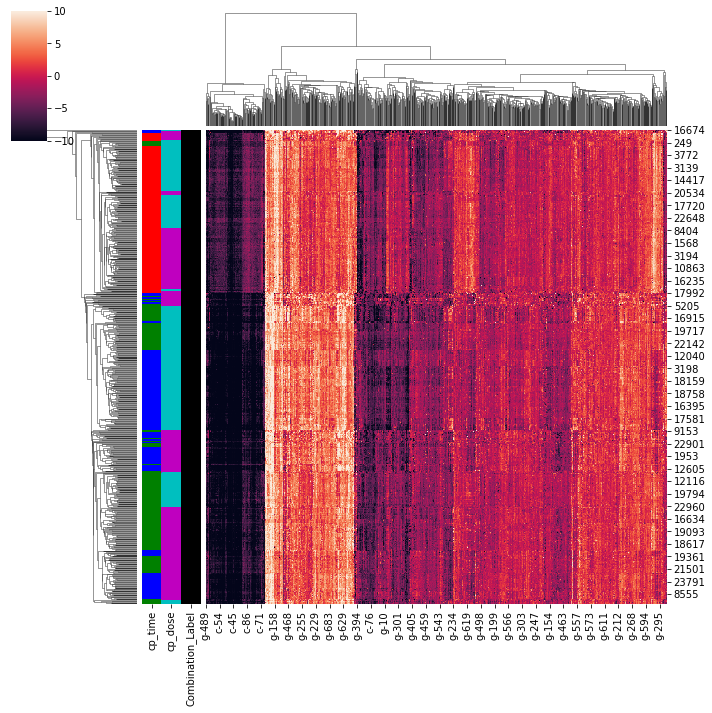

In [21]:
plot_clustermap(df_full_combine, 'Combination_Label', 1)

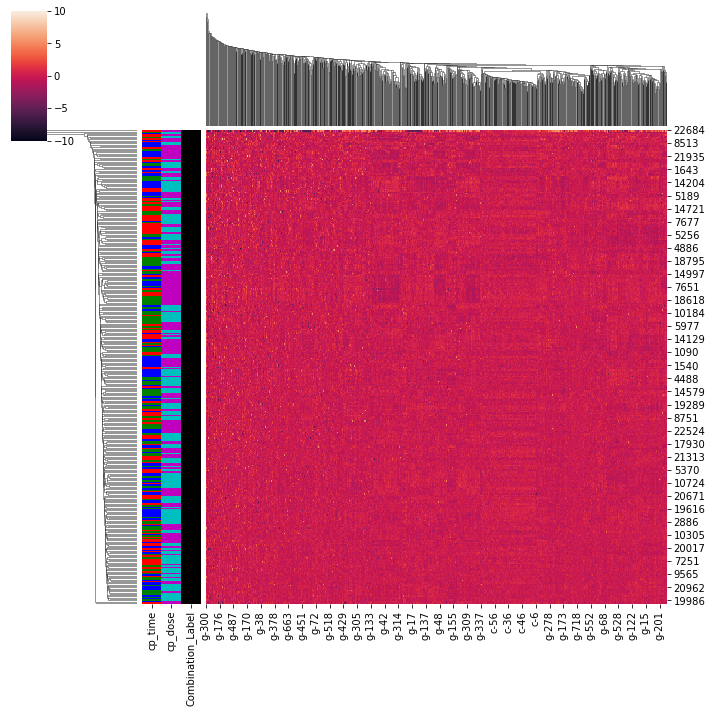

In [54]:
plot_clustermap(df_full_combine, 'Combination_Label', 2)

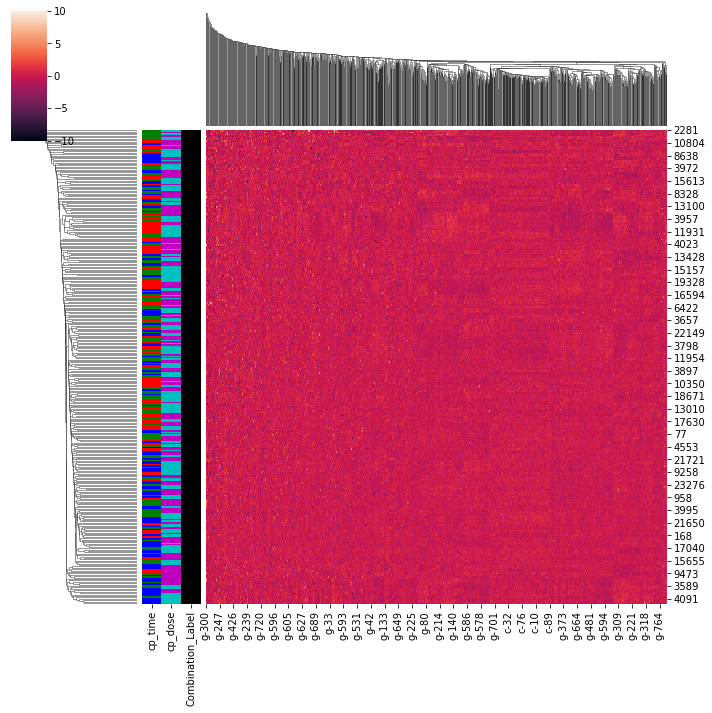

In [55]:
plot_clustermap(df_full_combine, 'Combination_Label', 3)

In [56]:
plot_clustermap(df_full_combine, 'Combination_Label', 4)

In [57]:
def plot_clustermap_compare(df, tar, val):
    df_sample = df[df[tar] == val]
    df_sample = pd.concat([df_sample, df[(df['cp_type'] == 'trt_cp') & (df[tar] == 0)].sample(df_sample.shape[0], random_state=2020)], axis=0)
    
    df_feature = df_sample.filter(regex='^(c|g)-')
    df_color = pd.DataFrame({'cp_time': df_sample['cp_time'].map({24: 'r', 48: 'g', 72: 'b'}), 
                             'cp_dose': df_sample['cp_dose'].map({'D1': 'c', 'D2': 'm'}), 
                             tar: df_sample[tar].map({0: 'w', val: 'k'})})
    sns.clustermap(df_feature, row_colors=df_color)

In [58]:
plot_clustermap_compare(df_full_combine, 'Combination_Label', 1)

In [22]:
def plot_clustermap_compare_target(df, tar, val):
    df_sample = df[df[tar] == val]
    df_sample = pd.concat([df_sample, df[(df['cp_type'] == 'trt_cp') & (df[tar] == 0)].sample(df_sample.shape[0], random_state=2020)], axis=0)
    cols = df_sample.filter(regex='^g-').columns
    df_sample[cols] = np.sort(df_sample[cols].values, axis=1)
    cols = df_sample.filter(regex='^c-').columns
    df_sample[cols] = np.sort(df_sample[cols].values, axis=1)
    
    df_feature = df_sample.filter(regex='^(c|g)-')
    df_feature['t-0'] = (df_sample[tar] - 0.5) * 10.0
    df_color = pd.DataFrame({'cp_time': df_sample['cp_time'].map({24: 'r', 48: 'g', 72: 'b'}), 
                             'cp_dose': df_sample['cp_dose'].map({'D1': 'c', 'D2': 'm'}), 
                             tar: df_sample[tar].map({0: 'w', 1: 'k'})})
    sns.clustermap(df_feature, row_colors=df_color, vmin=-5.0, vmax=+5.0)


<ipython-input-22-4cf060f7ade1>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_feature['t-0'] = (df_sample[tar] - 0.5) * 10.0


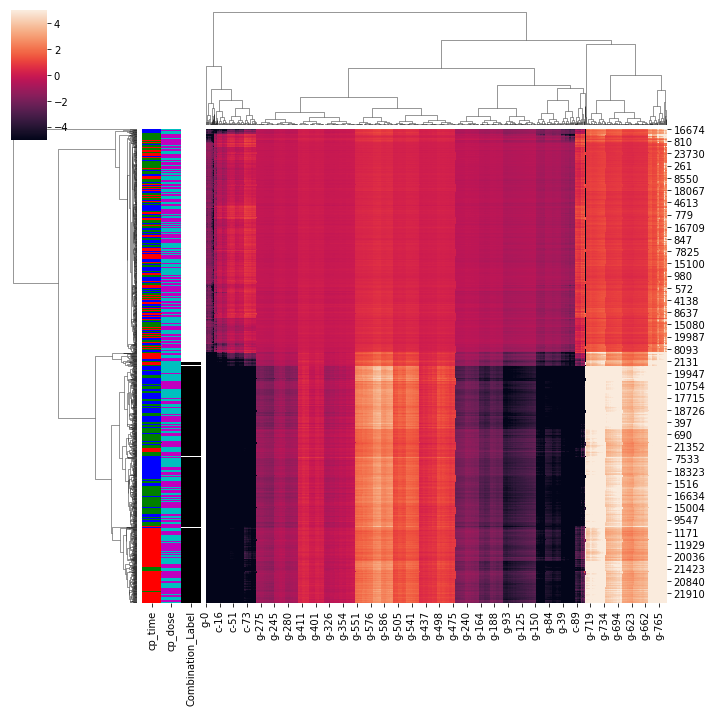

In [24]:
plot_clustermap_compare_target(df_full_combine, 'Combination_Label', 1)

In [ ]:
def plot_clustermap_compare_ordered(df, tar):
    df_sample = df[df[tar] == 1]
    df_sample = pd.concat([df_sample, df[(df['cp_type'] == 'trt_cp') & (df[tar] == 0)].sample(df_sample.shape[0], random_state=2020)], axis=0)
    cols = df_sample.filter(regex='^g-').columns
    df_sample[cols] = np.sort(df_sample[cols].values, axis=1)
    cols = df_sample.filter(regex='^c-').columns
    df_sample[cols] = np.sort(df_sample[cols].values, axis=1)
    
    df_feature = df_sample.filter(regex='^(c|g)-')
    df_color = pd.DataFrame({'cp_time': df_sample['cp_time'].map({24: 'r', 48: 'g', 72: 'b'}), 
                             'cp_dose': df_sample['cp_dose'].map({'D1': 'c', 'D2': 'm'}), 
                             tar: df_sample[tar].map({0: 'w', 1: 'k'})})
    sns.clustermap(df_feature, row_colors=df_color)


## target encoding with the combination labels

In [25]:
df_full_combine.head()

cp_type  cp_time cp_dose     g-0     g-1     g-2     g-3     g-4     g-5  \
0  trt_cp       24      D1  1.0620  0.5577 -0.2479 -0.6208 -0.1944 -1.0120   
1  trt_cp       72      D1  0.0743  0.4087  0.2991  0.0604  1.0190  0.5207   
2  trt_cp       48      D1  0.6280  0.5817  1.5540 -0.0764 -0.0323  1.2390   
3  trt_cp       48      D1 -0.5138 -0.2491 -0.2656  0.5288  4.0620 -0.8095   
4  trt_cp       72      D2 -0.3254 -0.4009  0.9700  0.6919  1.4180 -0.8244   

      g-6     g-7     g-8     g-9    g-10    g-11    g-12    g-13    g-14  \
0 -1.0220 -0.0326  0.5548 -0.0921  1.1830  0.1530  0.5574 -0.4015  0.1789   
1  0.2341  0.3372 -0.4047  0.8507 -1.1520 -0.4201 -0.0958  0.4590  0.0803   
2  0.1715  0.2155  0.0065  1.2300 -0.4797 -0.5631 -0.0366 -1.8300  0.6057   
3 -1.9590  0.1792 -0.1321 -1.0600 -0.8269 -0.3584 -0.8511 -0.5844 -2.5690   
4 -0.2800 -0.1498 -0.8789  0.8630 -0.2219 -0.5121 -0.9577  1.1750  0.2042   

     g-15    g-16    g-17    g-18    g-19    g-20    g-21    g-22    g-23  \
0 -0.6528 -0.7969  0.6342  0.1778 -0.3694 -0.5688 -1.1360 -1.1880  0.6940   
1  0.2250  0.5293  0.2839 -0.3494  0.2883  0.9449 -0.1646 -0.2657 -0.3372   
2 -0.3278  0.6042 -0.3075 -0.1147 -0.0570 -0.0799 -0.8181 -1.5320  0.2307   
3  0.8183 -0.0532 -0.8554  0.1160 -2.3520  2.1200 -1.1580 -0.7191 -0.8004   
4  0.1970  0.1244 -1.7090 -0.3543 -0.5160 -0.3330 -0.2685  0.7649  0.2057   

     g-24    g-25    g-26    g-27    g-28    g-29    g-30    g-31    g-32  \
0  0.4393  0.2664  0.1907  0.1628 -0.2853  0.5819  0.2934 -0.5584 -0.0916   
1  0.3135 -0.4316  0.4773  0.2075 -0.4216 -0.1161 -0.0499 -0.2627  0.9959   
2  0.4901  0.4780 -1.3970  4.6240 -0.0437  1.2870 -1.8530  0.6069  0.4290   
3 -1.4670 -0.0107 -0.8995  0.2406 -0.2479 -1.0890 -0.7575  0.0881 -2.7370   
4  1.3720  0.6835  0.8056 -0.3754 -1.2090  0.2965 -0.0712  0.6389  0.6674   

     g-33    g-34    g-35    g-36    g-37    g-38    g-39    g-40    g-41  \
0 -0.3010 -0.1537  0.2198  0.2965 -0.5055 -0.5119 -0.2162 -0.0347 -0.2566   
1 -0.2483  0.2655 -0.2102  0.1656  0.5300 -0.2568 -0.0455  0.1194 -0.3958   
2  0.1783  0.0018 -1.1800  0.1256 -0.1219  5.4470  1.0310  0.3477 -0.5561   
3  0.8745  0.5787 -1.6740 -1.6720 -1.2690  3.0900 -0.3814 -0.7229 -0.0010   
4 -0.0783  1.1740 -0.7110 -1.4470  1.0620  0.7888 -0.0848  0.1302  0.1224   

     g-42    g-43    g-44    g-45    g-46    g-47    g-48    g-49    g-50  \
0 -1.1980  0.3116 -1.0330  0.2208 -0.1143 -0.0251  0.0350  0.4233 -0.1221   
1 -1.1730  0.4509  1.9250  1.1010  0.2648 -0.3615  0.1710 -0.8900  1.2730   
2  0.0357 -0.3636 -0.4653 -0.8346  0.1113 -0.7615 -0.4983  0.4552 -0.0978   
3  0.1353 -1.6400 -0.7483 -1.0820 -0.1521  0.0747 -0.4851  0.6636 -2.8230   
4  0.9584  0.2126  0.6162  1.1570  1.1140 -0.9416 -0.3780 -0.8147 -0.0803   

     g-51    g-52    g-53    g-54    g-55    g-56    g-57    g-58    g-59  \
0 -0.4927  0.6119  0.4715 -0.0351 -0.1605 -0.6750  0.2263  0.5790  0.9588   
1 -0.5036 -0.2277 -0.7339 -0.4283 -0.1231 -0.6328  0.4759  0.3249 -0.7408   
2 -0.2661  0.6058  0.2686 -0.6191 -0.4444  1.2540  0.0621 -0.1757 -1.4370   
3 -0.6035 -1.3550  2.0200 -0.5301 -1.3240 -0.5936  0.4331  0.0899 -1.5240   
4 -0.3818  0.6877  0.0000  0.1776  1.1320 -0.1180  1.2130  0.7709  0.6745   

     g-60    g-61    g-62    g-63    g-64    g-65    g-66    g-67    g-68  \
0  0.6061 -0.1300  0.6611 -0.3136 -0.2020  0.0251  0.1670 -0.4195  0.6551   
1 -0.5814  1.7840 -0.1087  1.0350  0.4087 -0.6948 -0.8026  0.0954 -0.4054   
2  0.5553  0.8346 -0.3334 -0.2933 -0.1644 -1.1280 -0.0292  0.0939  0.5916   
3  0.3936  1.4630 -1.2100 -1.2340 -1.0300  0.7977  0.2314  0.1186  1.5370   
4  0.7871  1.6410  0.1806  1.3480  1.1070  0.5392  0.0000  0.1255 -0.1556   

     g-69    g-70    g-71    g-72    g-73    g-74    g-75    g-76    g-77  \
0 -0.7395 -0.7047 -0.5369  0.0314 -0.5239 -0.3406 -0.6332 -1.0330 -0.3763   
1  0.1197  0.1956  0.0720 -0.2463 -0.1084  0.4008 -0.5857  0.8933  0.2842   
2  0.6809  0.7821  0.6801  0.9634  0.4057 -0.0708 -1.3570  0.

In [43]:
print(df_full_combine.Combination_Count.value_counts()[:50])
print(df_full_combine.Combination_Count.value_counts()[50:])

5530    5530
6       1782
12      1044
18       774
718      718
30       600
24       552
42       546
25       425
363      363
337      337
328      328
310      310
304      304
295      295
293      293
292      292
36       288
288      288
283      283
54       270
263      263
255      255
251      251
61       244
240      240
229      229
19       228
56       224
221      221
218      218
72       216
216      216
205      205
102      204
66       198
7        196
31       186
186      186
184      184
13       182
91       182
180      180
37       148
73       146
71       142
67       134
129      129
128      128
60       120
Name: Combination_Count, dtype: int64
59     118
115    115
55     110
103    103
50     100
49      98
48      96
94      94
93      93
92      92
90      90
89      89
43      86
85      85
83      83
20      80
80      80
77      77
76      76
74      74
70      70
68      68
11      66
62      62
29      58
53      53
23      46
44      44
41  

In [52]:
df_full_combine.Combination_Count[(df_full_combine.Combination_Count>24) & (df_full_combine.Combination_Count< 2000)].size

13276

In [49]:
np.sort(df_full_combine.Combination_Count.unique())

array([   1,    2,    5,    6,    7,    8,   11,   12,   13,   17,   18,
         19,   20,   23,   24,   25,   26,   29,   30,   31,   32,   35,
         36,   37,   39,   41,   42,   43,   44,   48,   49,   50,   53,
         54,   55,   56,   59,   60,   61,   62,   66,   67,   68,   70,
         71,   72,   73,   74,   76,   77,   80,   83,   85,   89,   90,
         91,   92,   93,   94,  102,  103,  115,  128,  129,  180,  184,
        186,  205,  216,  218,  221,  229,  240,  251,  255,  263,  283,
        288,  292,  293,  295,  304,  310,  328,  337,  363,  718, 5530],
      dtype=int64)

In [54]:
df_full_combine.cp_type.unique()

array(['trt_cp', 'ctl_vehicle'], dtype=object)

In [55]:
df_full_combine.columns[-10:]

Index(['c-95', 'c-96', 'c-97', 'c-98', 'c-99', 'count_scored',
       'count_nonscored', 'count_total', 'Combination_Label',
       'Combination_Count'],
      dtype='object')

In [12]:
df_full_trt = df_full_combine[df_full_combine.cp_type !='ctl_vehicle']
df_train = df_full_trt.drop(columns=['count_scored',
       'count_nonscored', 'count_total', 
       'Combination_Count'] ).reset_index(drop = True).drop('cp_type', axis = 1)
df_target = df_full_trt.Combination_Label.reset_index(drop = True)

In [68]:
df_full_trt.head()

cp_type  cp_time cp_dose     g-0     g-1     g-2     g-3     g-4     g-5  \
0  trt_cp       24      D1  1.0620  0.5577 -0.2479 -0.6208 -0.1944 -1.0120   
1  trt_cp       72      D1  0.0743  0.4087  0.2991  0.0604  1.0190  0.5207   
2  trt_cp       48      D1  0.6280  0.5817  1.5540 -0.0764 -0.0323  1.2390   
3  trt_cp       48      D1 -0.5138 -0.2491 -0.2656  0.5288  4.0620 -0.8095   
4  trt_cp       72      D2 -0.3254 -0.4009  0.9700  0.6919  1.4180 -0.8244   

      g-6     g-7     g-8     g-9    g-10    g-11    g-12    g-13    g-14  \
0 -1.0220 -0.0326  0.5548 -0.0921  1.1830  0.1530  0.5574 -0.4015  0.1789   
1  0.2341  0.3372 -0.4047  0.8507 -1.1520 -0.4201 -0.0958  0.4590  0.0803   
2  0.1715  0.2155  0.0065  1.2300 -0.4797 -0.5631 -0.0366 -1.8300  0.6057   
3 -1.9590  0.1792 -0.1321 -1.0600 -0.8269 -0.3584 -0.8511 -0.5844 -2.5690   
4 -0.2800 -0.1498 -0.8789  0.8630 -0.2219 -0.5121 -0.9577  1.1750  0.2042   

     g-15    g-16    g-17    g-18    g-19    g-20    g-21    g-22    g-23  \
0 -0.6528 -0.7969  0.6342  0.1778 -0.3694 -0.5688 -1.1360 -1.1880  0.6940   
1  0.2250  0.5293  0.2839 -0.3494  0.2883  0.9449 -0.1646 -0.2657 -0.3372   
2 -0.3278  0.6042 -0.3075 -0.1147 -0.0570 -0.0799 -0.8181 -1.5320  0.2307   
3  0.8183 -0.0532 -0.8554  0.1160 -2.3520  2.1200 -1.1580 -0.7191 -0.8004   
4  0.1970  0.1244 -1.7090 -0.3543 -0.5160 -0.3330 -0.2685  0.7649  0.2057   

     g-24    g-25    g-26    g-27    g-28    g-29    g-30    g-31    g-32  \
0  0.4393  0.2664  0.1907  0.1628 -0.2853  0.5819  0.2934 -0.5584 -0.0916   
1  0.3135 -0.4316  0.4773  0.2075 -0.4216 -0.1161 -0.0499 -0.2627  0.9959   
2  0.4901  0.4780 -1.3970  4.6240 -0.0437  1.2870 -1.8530  0.6069  0.4290   
3 -1.4670 -0.0107 -0.8995  0.2406 -0.2479 -1.0890 -0.7575  0.0881 -2.7370   
4  1.3720  0.6835  0.8056 -0.3754 -1.2090  0.2965 -0.0712  0.6389  0.6674   

     g-33    g-34    g-35    g-36    g-37    g-38    g-39    g-40    g-41  \
0 -0.3010 -0.1537  0.2198  0.2965 -0.5055 -0.5119 -0.2162 -0.0347 -0.2566   
1 -0.2483  0.2655 -0.2102  0.1656  0.5300 -0.2568 -0.0455  0.1194 -0.3958   
2  0.1783  0.0018 -1.1800  0.1256 -0.1219  5.4470  1.0310  0.3477 -0.5561   
3  0.8745  0.5787 -1.6740 -1.6720 -1.2690  3.0900 -0.3814 -0.7229 -0.0010   
4 -0.0783  1.1740 -0.7110 -1.4470  1.0620  0.7888 -0.0848  0.1302  0.1224   

     g-42    g-43    g-44    g-45    g-46    g-47    g-48    g-49    g-50  \
0 -1.1980  0.3116 -1.0330  0.2208 -0.1143 -0.0251  0.0350  0.4233 -0.1221   
1 -1.1730  0.4509  1.9250  1.1010  0.2648 -0.3615  0.1710 -0.8900  1.2730   
2  0.0357 -0.3636 -0.4653 -0.8346  0.1113 -0.7615 -0.4983  0.4552 -0.0978   
3  0.1353 -1.6400 -0.7483 -1.0820 -0.1521  0.0747 -0.4851  0.6636 -2.8230   
4  0.9584  0.2126  0.6162  1.1570  1.1140 -0.9416 -0.3780 -0.8147 -0.0803   

     g-51    g-52    g-53    g-54    g-55    g-56    g-57    g-58    g-59  \
0 -0.4927  0.6119  0.4715 -0.0351 -0.1605 -0.6750  0.2263  0.5790  0.9588   
1 -0.5036 -0.2277 -0.7339 -0.4283 -0.1231 -0.6328  0.4759  0.3249 -0.7408   
2 -0.2661  0.6058  0.2686 -0.6191 -0.4444  1.2540  0.0621 -0.1757 -1.4370   
3 -0.6035 -1.3550  2.0200 -0.5301 -1.3240 -0.5936  0.4331  0.0899 -1.5240   
4 -0.3818  0.6877  0.0000  0.1776  1.1320 -0.1180  1.2130  0.7709  0.6745   

     g-60    g-61    g-62    g-63    g-64    g-65    g-66    g-67    g-68  \
0  0.6061 -0.1300  0.6611 -0.3136 -0.2020  0.0251  0.1670 -0.4195  0.6551   
1 -0.5814  1.7840 -0.1087  1.0350  0.4087 -0.6948 -0.8026  0.0954 -0.4054   
2  0.5553  0.8346 -0.3334 -0.2933 -0.1644 -1.1280 -0.0292  0.0939  0.5916   
3  0.3936  1.4630 -1.2100 -1.2340 -1.0300  0.7977  0.2314  0.1186  1.5370   
4  0.7871  1.6410  0.1806  1.3480  1.1070  0.5392  0.0000  0.1255 -0.1556   

     g-69    g-70    g-71    g-72    g-73    g-74    g-75    g-76    g-77  \
0 -0.7395 -0.7047 -0.5369  0.0314 -0.5239 -0.3406 -0.6332 -1.0330 -0.3763   
1  0.1197  0.1956  0.0720 -0.2463 -0.1084  0.4008 -0.5857  0.8933  0.2842   
2  0.6809  0.7821  0.6801  0.9634  0.4057 -0.0708 -1.3570  0.

0     93
1      0
2    365
3      0
4     14
Name: Combination_Label, dtype: int64

In [14]:
df_target_OHE = pd.get_dummies(df_target) 

In [52]:
df_target_OHE

0    1    2    3    4    5    6    7    8    9    10   11   12   13   \
0        0    0    0    0    0    0    0    0    0    0    0    0    0    0   
1        1    0    0    0    0    0    0    0    0    0    0    0    0    0   
2        0    0    0    0    0    0    0    0    0    0    0    0    0    0   
3        1    0    0    0    0    0    0    0    0    0    0    0    0    0   
4        0    0    0    0    0    0    0    0    0    0    0    0    0    0   
...    ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
21943    0    0    0    0    0    0    0    0    0    0    0    0    0    0   
21944    0    0    0    0    0    0    0    0    0    0    1    0    0    0   
21945    0    0    0    0    0    0    0    0    0    0    0    0    0    0   
21946    0    0    0    0    0    0    1    0    0    0    0    0    0    0   
21947    1    0    0    0    0    0    0    0    0    0    0    0    0    0   

       14   15   16   17   18   19   20   21   22   23   24   25   26   27   \
0        0    0    0    0    0    0    0    0    0    0    0    0    0    0   
1        0    0    0    0    0    0    0    0    0    0    0    0    0    0   
2        0    0    0    0    0    0    0    0    0    0    0    0    0    0   
3        0    0    0    0    0    0    0    0    0    0    0    0    0    0   
4        1    0    0    0    0    0    0    0    0    0    0    0    0    0   
...    ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
21943    0    0    0    0    0    0    0    0    0    0    0    0    0    0   
21944    0    0    0    0    0    0    0    0    0    0    0    0    0    0   
21945    0    0    0    0    0    0    0    0    0    0    0    0    0    0   
21946    0    0    0    0    0    0    0    0    0    0    0    0    0    0   
21947    0    0    0    0    0    0    0    0    0    0    0    0    0    0   

       28   29   30   31   32   33   34   35   36   37   38   39   40   41   \
0        0    0    0    0    0    0    0    0    0    0    0    0    0    0   
1        0    0    0    0    0    0    0    0    0    0    0    0    0    0   
2        0    0    0    0    0    0    0    0    0    0    0    0    0    0   
3        0    0    0    0    0    0    0    0    0    0    0    0    0    0   
4        0    0    0    0    0    0    0    0    0    0    0    0    0    0   
...    ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
21943    0    0    0    0    0    0    0    0    0    0    0    0    0    0   
21944    0    0    0    0    0    0    0    0    0    0    0    0    0    0   
21945    0    0    0    0    0    0    0    0    0    0    0    0    0    0   
21946    0    0    0    0    0    0    0    0    0    0    0    0    0    0   
21947    0    0    0    0    0    0    0    0    0    0    0    0    0    0   

       42   43   44   45   46   47   48   49   50   51   52   53   54   55   \
0        0    0    0    0    0    0    0    0    0    0    0    0    0    0   
1        0    0    0    0    0    0    0    0    0    0    0    0    0    0   
2        0    0    0    0    0    0    0    0    0    0    0    0    0    0   
3        0    0    0    0    0    0    0    0    0    0    0    0    0    0   
4        0    0    0    0    0    0    0    0    0    0    0    0    0    0   
...    ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
21943    0    0    0    0    0    1    0    0    0    0    0    0    0    0   
21944    0    0    0    0    0    0    0    0    0    0    0    0    0    0   
21945    0    0    0    0    0    0    0    0    0    0    0    0    0    0   
21946    0    0    0    0    0    0    0    0    0    0    0    0    0    0   
21947    0    0    0    0    0    0    0    0    0    0    0    0    0    0   

       56   57   58   59   60   61   62   63   64   65   66   67   68   69   \
0        0    0    0    0    0    0    0    0    0    0    0    0    0    0   
1        0    0    0    0    0    0    0    0    0   

In [15]:
df_test = df['test_features'][df['test_features']['cp_type']!='ctl_vehicle'].reset_index(drop = True).drop('cp_type',axis = 1)

In [16]:
df_test.head()

cp_time cp_dose     g-0     g-1     g-2     g-3     g-4     g-5     g-6  \
0       24      D1 -0.5458  0.1306 -0.5135  0.4408  1.5500 -0.1644 -0.2140   
1       72      D1 -0.1829  0.2320  1.2080 -0.4522 -0.3652 -0.3319 -1.8820   
2       24      D2  0.4828  0.1955  0.3825  0.4244 -0.5855 -1.2020  0.5998   
3       48      D1 -0.3979 -1.2680  1.9130  0.2057 -0.5864 -0.0166  0.5128   
4       48      D2  0.3658  0.5536 -0.6898 -1.6270  0.5239 -0.3832 -0.4653   

      g-7     g-8     g-9    g-10    g-11    g-12    g-13    g-14    g-15  \
0  0.2221 -0.3260  1.9390 -0.2305 -0.3670  1.3040  1.4610  0.0043  0.6816   
1  0.4022 -0.3528  0.1271  0.9303  0.3173 -1.0120 -0.3213  0.0607 -0.5389   
2 -0.1799  0.9365  0.2942  1.3990 -1.1080  1.1610 -0.8134  0.0743 -0.3096   
3  0.6365  0.2611 -1.1120 -0.1747 -0.2053 -0.0006  0.0254  0.1784 -0.1314   
4  1.0070  0.3726  0.0811 -0.2860 -0.7182 -0.1714 -0.6262 -2.0100  0.0202   

     g-16    g-17    g-18    g-19    g-20    g-21    g-22    g-23    g-24  \
0 -0.2304 -0.0635 -0.2030 -0.6821 -0.6242  0.1297 -0.0338  0.3372  0.2254   
1 -0.8030 -1.0600 -0.0978 -0.8156 -0.6514  0.6812  0.5246  0.0000  0.5030   
2 -0.9956  1.7100  1.2200 -0.1258 -0.5900 -0.7956 -0.6765  0.0000 -0.8820   
3  1.0700  0.0477 -0.0756  0.1287  0.1403  0.7609 -0.1095  0.0000 -1.0950   
4 -0.9239  0.6774 -0.4465 -1.2390 -0.6965  0.8263 -0.4222  0.4229  0.5767   

     g-25    g-26    g-27    g-28    g-29    g-30    g-31    g-32    g-33  \
0  0.4795  0.7642  0.6638 -0.2480 -0.1183 -0.4847 -0.0179 -0.8204 -0.5296   
1 -0.1500 -0.1433  2.0910 -0.6556 -0.6012 -0.4104 -0.0580 -0.3608  0.2197   
2  0.7609 -0.0882  0.5217  0.9587 -0.4764  0.2690  0.4753  0.0196  0.2775   
3 -0.0780  0.9048 -0.3007  0.4351 -0.1558  0.2101  0.4850  0.1139  0.6745   
4 -0.5555 -0.3332 -0.4988 -0.3260 -0.8819  0.1599 -0.1260  0.2291 -0.0672   

     g-34    g-35    g-36    g-37    g-38    g-39    g-40    g-41    g-42  \
0 -1.5070 -0.0144  0.4448  0.5753 -0.2993 -0.9532 -0.1443 -1.0880  0.2080   
1 -0.7101  1.3430 -0.9605 -1.1920  0.3733  0.0216 -0.1787 -0.4277  1.2110   
2 -0.7142  0.7079  0.4006 -0.0175  0.5904 -0.1295 -0.1021 -0.0480 -0.7627   
3 -0.9101 -0.6690  1.6320 -0.0910 -0.2841 -0.0883  1.7570  2.0050 -0.8237   
4 -0.9733  0.8242 -0.6059 -1.0020 -0.7810 -1.0120 -0.0508 -0.4222  1.0280   

     g-43    g-44    g-45    g-46    g-47    g-48    g-49    g-50    g-51  \
0  0.5670  1.1190 -0.0455  0.2789 -1.0230 -0.6231 -0.6682 -0.0718 -1.5240   
1  0.1401 -1.0940  0.7750  0.0000  2.3690 -0.1453 -1.0800 -1.1160 -0.1209   
2 -0.3995  0.2503 -1.9450  0.3880  0.1098  0.3617 -0.3092  0.6467  0.0491   
3  0.3234  0.2379 -1.4110 -0.1383  0.0630  0.2198 -0.5721  0.1917 -0.3863   
4  1.5310 -0.7614  0.3405 -0.2455 -0.7095  0.0104 -0.1353 -0.2634  0.1305   

     g-52    g-53    g-54    g-55    g-56    g-57    g-58    g-59    g-60  \
0  0.9117  0.6883 -0.1073 -0.1134  0.4536  5.5140  0.3271  0.1388 -0.2321   
1  0.0668 -0.8654 -1.0150  0.5382  1.3060  0.2869 -0.8135  0.4051  1.2760   
2 -0.3468  0.4760 -0.3444 -0.2431  1.0410  0.3487  0.9301 -0.3713 -0.4061   
3  0.1559  0.1903  0.4977  0.7420  1.1110  0.4917 -0.0232  0.2063 -0.7254   
4 -0.0078 -0.7819 -0.5895  0.9445  1.1200 -0.1126  0.2738  1.0980 -0.8253   

     g-61    g-62    g-63    g-64    g-65    g-66    g-67    g-68    g-69  \
0  1.5170  0.0546  0.9043 -0.3088  1.5360  0.1511 -0.3711 -0.0195 -0.4992   
1 -0.6459  0.5404 -0.1757 -0.0274  0.7104  0.8514  0.9873  0.7911 -0.3199   
2 -0.5070  0.9324 -0.2296 -0.6001 -1.7580 -0.7311  1.0810 -0.9770 -0.4064   
3  0.5947  0.3108  0.6921  1.0250 -0.8283 -0.5511 -0.4887  0.1133  1.6050   
4  0.6871  1.0830  0.1370  0.7602 -0.2567 -0.3794 -0.9847 -0.1544 -1.0410   

     g-70    g-71    g-72    g-73    g-74    g-75    g-76    g-77    g-78  \
0  1.2080 -0.3614  0.7978  0.3076  0.5958  0.4006  0.3546 -0.0423  0.3159   
1  0.8688 -1.2900 -0.8000  0.6292 -1.2300 -0.2149 -1.3020 -0.7832 -0.7155   
2 -0.0391  0.2864 -0.3455  0.0254  0.1015  0.6278 -0.5969 -0.6

## CV folds

In [17]:
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=5, random_state=2020, shuffle= True)

In [18]:
folds = df_train.copy()

for f, (train_index, val_index)  in enumerate(skf.split(X= df_train, y=df_target)):
    folds.loc[val_index, 'kfold'] = int(f)
    
folds['kfold'] =folds['kfold'].astype(int)
folds.head()

cp_time cp_dose     g-0     g-1     g-2     g-3     g-4     g-5     g-6  \
0       24      D1  1.0620  0.5577 -0.2479 -0.6208 -0.1944 -1.0120 -1.0220   
1       72      D1  0.0743  0.4087  0.2991  0.0604  1.0190  0.5207  0.2341   
2       48      D1  0.6280  0.5817  1.5540 -0.0764 -0.0323  1.2390  0.1715   
3       48      D1 -0.5138 -0.2491 -0.2656  0.5288  4.0620 -0.8095 -1.9590   
4       72      D2 -0.3254 -0.4009  0.9700  0.6919  1.4180 -0.8244 -0.2800   

      g-7     g-8     g-9    g-10    g-11    g-12    g-13    g-14    g-15  \
0 -0.0326  0.5548 -0.0921  1.1830  0.1530  0.5574 -0.4015  0.1789 -0.6528   
1  0.3372 -0.4047  0.8507 -1.1520 -0.4201 -0.0958  0.4590  0.0803  0.2250   
2  0.2155  0.0065  1.2300 -0.4797 -0.5631 -0.0366 -1.8300  0.6057 -0.3278   
3  0.1792 -0.1321 -1.0600 -0.8269 -0.3584 -0.8511 -0.5844 -2.5690  0.8183   
4 -0.1498 -0.8789  0.8630 -0.2219 -0.5121 -0.9577  1.1750  0.2042  0.1970   

     g-16    g-17    g-18    g-19    g-20    g-21    g-22    g-23    g-24  \
0 -0.7969  0.6342  0.1778 -0.3694 -0.5688 -1.1360 -1.1880  0.6940  0.4393   
1  0.5293  0.2839 -0.3494  0.2883  0.9449 -0.1646 -0.2657 -0.3372  0.3135   
2  0.6042 -0.3075 -0.1147 -0.0570 -0.0799 -0.8181 -1.5320  0.2307  0.4901   
3 -0.0532 -0.8554  0.1160 -2.3520  2.1200 -1.1580 -0.7191 -0.8004 -1.4670   
4  0.1244 -1.7090 -0.3543 -0.5160 -0.3330 -0.2685  0.7649  0.2057  1.3720   

     g-25    g-26    g-27    g-28    g-29    g-30    g-31    g-32    g-33  \
0  0.2664  0.1907  0.1628 -0.2853  0.5819  0.2934 -0.5584 -0.0916 -0.3010   
1 -0.4316  0.4773  0.2075 -0.4216 -0.1161 -0.0499 -0.2627  0.9959 -0.2483   
2  0.4780 -1.3970  4.6240 -0.0437  1.2870 -1.8530  0.6069  0.4290  0.1783   
3 -0.0107 -0.8995  0.2406 -0.2479 -1.0890 -0.7575  0.0881 -2.7370  0.8745   
4  0.6835  0.8056 -0.3754 -1.2090  0.2965 -0.0712  0.6389  0.6674 -0.0783   

     g-34    g-35    g-36    g-37    g-38    g-39    g-40    g-41    g-42  \
0 -0.1537  0.2198  0.2965 -0.5055 -0.5119 -0.2162 -0.0347 -0.2566 -1.1980   
1  0.2655 -0.2102  0.1656  0.5300 -0.2568 -0.0455  0.1194 -0.3958 -1.1730   
2  0.0018 -1.1800  0.1256 -0.1219  5.4470  1.0310  0.3477 -0.5561  0.0357   
3  0.5787 -1.6740 -1.6720 -1.2690  3.0900 -0.3814 -0.7229 -0.0010  0.1353   
4  1.1740 -0.7110 -1.4470  1.0620  0.7888 -0.0848  0.1302  0.1224  0.9584   

     g-43    g-44    g-45    g-46    g-47    g-48    g-49    g-50    g-51  \
0  0.3116 -1.0330  0.2208 -0.1143 -0.0251  0.0350  0.4233 -0.1221 -0.4927   
1  0.4509  1.9250  1.1010  0.2648 -0.3615  0.1710 -0.8900  1.2730 -0.5036   
2 -0.3636 -0.4653 -0.8346  0.1113 -0.7615 -0.4983  0.4552 -0.0978 -0.2661   
3 -1.6400 -0.7483 -1.0820 -0.1521  0.0747 -0.4851  0.6636 -2.8230 -0.6035   
4  0.2126  0.6162  1.1570  1.1140 -0.9416 -0.3780 -0.8147 -0.0803 -0.3818   

     g-52    g-53    g-54    g-55    g-56    g-57    g-58    g-59    g-60  \
0  0.6119  0.4715 -0.0351 -0.1605 -0.6750  0.2263  0.5790  0.9588  0.6061   
1 -0.2277 -0.7339 -0.4283 -0.1231 -0.6328  0.4759  0.3249 -0.7408 -0.5814   
2  0.6058  0.2686 -0.6191 -0.4444  1.2540  0.0621 -0.1757 -1.4370  0.5553   
3 -1.3550  2.0200 -0.5301 -1.3240 -0.5936  0.4331  0.0899 -1.5240  0.3936   
4  0.6877  0.0000  0.1776  1.1320 -0.1180  1.2130  0.7709  0.6745  0.7871   

     g-61    g-62    g-63    g-64    g-65    g-66    g-67    g-68    g-69  \
0 -0.1300  0.6611 -0.3136 -0.2020  0.0251  0.1670 -0.4195  0.6551 -0.7395   
1  1.7840 -0.1087  1.0350  0.4087 -0.6948 -0.8026  0.0954 -0.4054  0.1197   
2  0.8346 -0.3334 -0.2933 -0.1644 -1.1280 -0.0292  0.0939  0.5916  0.6809   
3  1.4630 -1.2100 -1.2340 -1.0300  0.7977  0.2314  0.1186  1.5370  0.3868   
4  1.6410  0.1806  1.3480  1.1070  0.5392  0.0000  0.1255 -0.1556 -0.5436   

     g-70    g-71    g-72    g-73    g-74    g-75    g-76    g-77    g-78  \
0 -0.7047 -0.5369  0.0314 -0.5239 -0.3406 -0.6332 -1.0330 -0.3763 -0.8550   
1  0.1956  0.0720 -0.2463 -0.1084  0.4008 -0.5857  0.8933  0.2842  1.1870   
2  0.7821  0.6801  0.9634  0.4057 -0.0708 -1.3570  0.2306 -0.4

In [60]:
val_index[:10]

array([ 4,  7, 21, 24, 27, 33, 38, 45, 50, 62])

In [61]:
val_index[:10]

array([ 4,  7, 21, 24, 27, 33, 38, 45, 50, 62])

## NN nets model

#### Dataset class

In [19]:
class MoADataset:
    def __init__(self, features, targets):
        self.features = features
        self.targets = targets
    #the __len__ and __getitem__ are for torch.utils.data.DataLoader to load batches into neural networks.    
    def __len__(self):
        return (self.features.shape[0])
    
    def __getitem__(self, idx):
        dct = {
            'x' : torch.tensor(self.features[idx, :], dtype=torch.float),
            'y' : torch.tensor(self.targets[idx, :], dtype=torch.float)            
        }
        return dct
    
class TestDataset:
    def __init__(self, features):
        self.features = features
        
    def __len__(self):
        return (self.features.shape[0])
    
    def __getitem__(self, idx):
        dct = {
            'x' : torch.tensor(self.features[idx, :], dtype=torch.float)
        }
        return dct
    

In [35]:
def train_fn(model, optimizer, scheduler, loss_fn, dataloader, device):
    # this is to tell the model that it is in train mode, thus use batch normalization and dropout.
    model.train()
    final_loss = 0
    
    for data in dataloader:
        optimizer.zero_grad()
        inputs, targets = data['x'].to(device), data['y'].to(device)
#         print(inputs.shape)
        outputs = model(inputs)
       # print("outputs shape: ",outputs.shape)
        #print("targets shape: ", targets.shape)
        loss = loss_fn(outputs, targets)
        loss.backward()
        optimizer.step()
        scheduler.step()
        
        final_loss += loss.item()
        
    final_loss /= len(dataloader)
    
    return final_loss


def valid_fn(model, loss_fn, dataloader, device):
    #model.eval() is to disable batch normalization and dropout.
    model.eval()
    final_loss = 0
    valid_preds = []
    
    for data in dataloader:
        inputs, targets = data['x'].to(device), data['y'].to(device)
        outputs = model(inputs)
        loss = loss_fn(outputs, targets)
        
        final_loss += loss.item()
        valid_preds.append(outputs.sigmoid().detach().cpu().numpy())
        
    final_loss /= len(dataloader)
    valid_preds = np.concatenate(valid_preds)
    
    return final_loss, valid_preds

def inference_fn(model, dataloader, device):
    model.eval()
    preds = []
    
    for data in dataloader:
        inputs = data['x'].to(device)
        
        #this saves memory and accelerate the running time as we don't need to keep memory for the gradients.
        with torch.no_grad():
            outputs = model(inputs)
        
        preds.append(outputs.sigmoid().detach().cpu().numpy())
        
    preds = np.concatenate(preds)
    
    return preds
   
    

### Model

In [21]:
class Model(nn.Module):
    def __init__(self, num_features, num_targets, hidden_size):
        super(Model, self).__init__()
        self.batch_norm1 = nn.BatchNorm1d(num_features)
        self.dropout1 = nn.Dropout(0.2)
        self.dense1 = nn.utils.weight_norm(nn.Linear(num_features, hidden_size))
        
        self.batch_norm2 = nn.BatchNorm1d(hidden_size)
        self.dropout2 = nn.Dropout(0.5)
        self.dense2 = nn.utils.weight_norm(nn.Linear(hidden_size, hidden_size))
        
        self.batch_norm3 = nn.BatchNorm1d(hidden_size)
        self.dropout3 = nn.Dropout(0.5)
        self.dense3 = nn.utils.weight_norm(nn.Linear(hidden_size, num_targets))
    
    def forward(self, x):
        x = self.batch_norm1(x)
        x = self.dropout1(x)
        x = F.relu(self.dense1(x))
        
        x = self.batch_norm2(x)
        x = self.dropout2(x)
        x = F.relu(self.dense2(x))
        
        x = self.batch_norm3(x)
        x = self.dropout3(x)
        x = self.dense3(x)
        
        return x

In [22]:
def process_data(data):
    
    data = pd.get_dummies(data, columns=['cp_time','cp_dose'])
    return data

In [23]:
feature_cols = [c for c in process_data(folds).columns if c!='Combination_Label']
feature_cols = [c for c in feature_cols if c not in ['kfold','sig_id']]
target_cols = ['Combination_Label']
len(feature_cols)

877

In [24]:
def seed_everything(seed=2020):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    
seed_everything(seed=2020)

In [32]:
# HyperParameters

DEVICE = ('cuda' if torch.cuda.is_available() else 'cpu')
EPOCHS = 10
BATCH_SIZE = 128
LEARNING_RATE = 1e-3
WEIGHT_DECAY = 1e-5
NFOLDS = 5
EARLY_STOPPING_STEPS = 10
EARLY_STOP = False

num_features=len(feature_cols)
num_targets=df_target_OHE.shape[1]
hidden_size=512


### Single fold training

In [33]:
print(df_target_OHE.shape)
df_train.shape

(21948, 696)


(21948, 875)

In [27]:
#need to modify the dataframe names
def run_training(fold, seed):
    
    seed_everything(seed)
    
    train = process_data(folds)
    test_ = process_data(df_test)
    
    trn_idx = train[train['kfold'] != fold].index
    val_idx = train[train['kfold'] == fold].index
    
    train_df = train[train['kfold'] != fold].reset_index(drop=True)
    valid_df = train[train['kfold'] == fold].reset_index(drop=True)
    
    train_target = df_target_OHE.iloc[trn_idx,:]
    val_target = df_target_OHE.iloc[val_idx,:]
    
    #x_train, y_train  = train_df[feature_cols].values, train_df[target_cols].values
    #x_valid, y_valid =  valid_df[feature_cols].values, valid_df[target_cols].values

    x_train, y_train = train_df[feature_cols].values, train_target.values
    x_valid, y_valid =  valid_df[feature_cols].values,val_target.values
    
    train_dataset = MoADataset(x_train, y_train)
    valid_dataset = MoADataset(x_valid, y_valid)
    trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    validloader = torch.utils.data.DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False)
    
    model = Model(
        num_features=num_features,
        num_targets=num_targets,
        hidden_size=hidden_size,
    )
    
    model.to(DEVICE)
    
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    #optimizer = torch.optim.RMsprop(model.parameters(), lr=LEARNING_RATE, alpha=0.99, eps=1e-08, weight_decay=0, momentum=0, centered=False)
    
    scheduler = optim.lr_scheduler.OneCycleLR(optimizer=optimizer, pct_start=0.1, div_factor=1e3, 
                                              max_lr=1e-2, epochs=EPOCHS, steps_per_epoch=len(trainloader))
    
    loss_fn = nn.BCEWithLogitsLoss()
    
    early_stopping_steps = EARLY_STOPPING_STEPS
    early_step = 0
    
    oof = np.zeros((len(df_train), df_target_OHE.shape[1]))
    best_loss = np.inf
    
    for epoch in range(EPOCHS):
        
        train_loss = train_fn(model, optimizer,scheduler, loss_fn, trainloader, DEVICE)
        print(f"FOLD: {fold}, EPOCH: {epoch}, train_loss: {train_loss}")
        valid_loss, valid_preds = valid_fn(model, loss_fn, validloader, DEVICE)
        print(f"FOLD: {fold}, EPOCH: {epoch}, valid_loss: {valid_loss}")
        
        if valid_loss < best_loss:
            
            best_loss = valid_loss
            oof[val_idx] = valid_preds
            torch.save(model.state_dict(), f"FOLD{fold}_.pth")
        
        elif(EARLY_STOP == True):
            
            early_step += 1
            if (early_step >= early_stopping_steps):
                break
            
    """"
    the following is not worked out yet as we need to transfer learn first
    or just put the combination back using transition matrix of size (696* 608)
    """
    
    #--------------------- PREDICTION---------------------
    x_test = test_[feature_cols].values
    testdataset = TestDataset(x_test)
    testloader = torch.utils.data.DataLoader(testdataset, batch_size=BATCH_SIZE, shuffle=False)
    
    model = Model(
        num_features=num_features,
        num_targets=num_targets,
        hidden_size=hidden_size,
    )
    
    model.load_state_dict(torch.load(f"FOLD{fold}_.pth"))
    model.to(DEVICE)
    
    #predictions = np.zeros((len(test_), target.iloc[:, 1:].shape[1]))
    predictions = np.zeros((len(test_), df_target_OHE.shape[1]))
    predictions = inference_fn(model, testloader, DEVICE)
    
    return oof, predictions
   

In [28]:
def run_k_fold(NFOLDS, seed):
    oof = np.zeros((len(df_train), df_target_OHE.shape[1]))
    predictions = np.zeros((len(df_test), df_target_OHE.shape[1] ))
    
    for fold in range(NFOLDS):
        oof_, pred_ = run_training(fold, seed)
        
        predictions += pred_ / NFOLDS
        oof += oof_
        
    return oof, predictions

In [36]:
#SEED = [0, 1, 2, 3 ,4, 5]
SEED = [2]
oof = np.zeros((len(df_train),df_target_OHE.shape[1] ))
predictions = np.zeros((len(df_test), df_target_OHE.shape[1]))

for seed in SEED:
    
    oof_, predictions_ = run_k_fold(NFOLDS, seed)
    oof += oof_ / len(SEED)
    predictions += predictions_ / len(SEED)

#train[target_cols] = oof
#test[target_cols] = predictions




FOLD: 0, EPOCH: 0, train_loss: 0.14884408379810443
FOLD: 0, EPOCH: 0, valid_loss: 0.009022981194513184
FOLD: 0, EPOCH: 1, train_loss: 0.009114402056118284
FOLD: 0, EPOCH: 1, valid_loss: 0.00871656917567764
FOLD: 1, EPOCH: 0, train_loss: 0.14865930746241973
FOLD: 1, EPOCH: 0, valid_loss: 0.009133851341903209
FOLD: 1, EPOCH: 1, train_loss: 0.009116870006951302
FOLD: 1, EPOCH: 1, valid_loss: 0.008705256187490054
FOLD: 2, EPOCH: 0, train_loss: 0.14930696097755994
FOLD: 2, EPOCH: 0, valid_loss: 0.009037966733532292
FOLD: 2, EPOCH: 1, train_loss: 0.009090463246178368
FOLD: 2, EPOCH: 1, valid_loss: 0.008708273193665914
FOLD: 3, EPOCH: 0, train_loss: 0.14873507494052898
FOLD: 3, EPOCH: 0, valid_loss: 0.009170785120555332
FOLD: 3, EPOCH: 1, train_loss: 0.00913558393527848
FOLD: 3, EPOCH: 1, valid_loss: 0.008713590885911669
FOLD: 4, EPOCH: 0, train_loss: 0.14889675023142193
FOLD: 4, EPOCH: 0, valid_loss: 0.008933598361909389
FOLD: 4, EPOCH: 1, train_loss: 0.009040693381288345
FOLD: 4, EPOCH: 1, 

In [41]:
print(oof.shape)
print(predictions.shape)

(21948, 696)
(3624, 696)


In [47]:
for i in range(oof.shape[0]):
    oof[i,:] = oof[i,:]/np.sum(oof[i,:])

In [54]:
oof_original_target = np.matmul(oof, transition.to_numpy() )
prediction_original_target = np.matmul(predictions,transition.to_numpy())

In [53]:
oof_original_target.shape

(21948, 608)

In [63]:
df['train_targets_scored'].head(20).iloc[:,[71,77,199]]

cyclooxygenase_inhibitor  dna_inhibitor  tubulin_inhibitor
sig_id                                                                  
id_000644bb2                         0              0                  0
id_000779bfc                         0              0                  0
id_000a6266a                         0              0                  0
id_0015fd391                         0              0                  0
id_001626bd3                         0              0                  0
id_001762a82                         0              0                  0
id_001bd861f                         0              0                  0
id_0020d0484                         0              0                  0
id_00224bf20                         0              0                  0
id_0023f063e                         0              0                  0
id_002452c7e                         0              0                  0
id_0024bcd70                         0              0                  0
id_0025c5949                         0              0                  0
id_00289dc6e                         0              1                  0
id_002d31e2c                         0              0                  0
id_002e08ff8                         0              0                  0
id_002fb9c19                         0              0                  0
id_0031dd989                         0              0                  0
id_003603254                         0              0                  0
id_0036b0342                         0              1                  0

In [82]:
train_log_loss = 0
num_of_scored_targets = df['train_targets_scored'].shape[1]

trt_index = df_full_combine[df_full_combine.cp_type !='ctl_vehicle'].index
for i in range(num_of_scored_targets):
    y_true = df['train_targets_scored'].iloc[trt_index,i].values
    y_pred = oof_original_target[:,i]
    train_log_loss += log_loss(y_true, y_pred)/num_of_scored_targets
train_log_loss

0.020631896271643475

In [79]:
df['train_targets_scored'].head()

5-alpha_reductase_inhibitor  11-beta-hsd1_inhibitor  \
sig_id                                                              
id_000644bb2                            0                       0   
id_000779bfc                            0                       0   
id_000a6266a                            0                       0   
id_0015fd391                            0                       0   
id_001626bd3                            0                       0   

              acat_inhibitor  acetylcholine_receptor_agonist  \
sig_id                                                         
id_000644bb2               0                               0   
id_000779bfc               0                               0   
id_000a6266a               0                               0   
id_0015fd391               0                               0   
id_001626bd3               0                               0   

              acetylcholine_receptor_antagonist  \
sig_id                                            
id_000644bb2                                  0   
id_000779bfc                                  0   
id_000a6266a                                  0   
id_0015fd391                                  0   
id_001626bd3                                  0   

              acetylcholinesterase_inhibitor  adenosine_receptor_agonist  \
sig_id                                                                     
id_000644bb2                               0                           0   
id_000779bfc                               0                           0   
id_000a6266a                               0                           0   
id_0015fd391                               0                           0   
id_001626bd3                               0                           0   

              adenosine_receptor_antagonist  adenylyl_cyclase_activator  \
sig_id                                                                    
id_000644bb2                              0                           0   
id_000779bfc                              0                           0   
id_000a6266a                              0                           0   
id_0015fd391                              0                           0   
id_001626bd3                              0                           0   

              adrenergic_receptor_agonist  adrenergic_receptor_antagonist  \
sig_id                                                                      
id_000644bb2                            0                               0   
id_000779bfc                            0                               0   
id_000a6266a                            0                               0   
id_0015fd391                            0                               0   
id_001626bd3                            0                               0   

              akt_inhibitor  aldehyde_dehydrogenase_inhibitor  alk_inhibitor  \
sig_id                                                                         
id_000644bb2              0                                 0              0   
id_000779bfc              0                                 0              0   
id_000a6266a              0                                 0              0   
id_0015fd391              0                                 0              0   
id_001626bd3              0                                 0              0   

              ampk_activator  analgesic  androgen_receptor_agonist  \
sig_id                                                               
id_000644bb2               0          0                          0   
id_000779bfc               0          0                          0   
id_000a6266a               0          0                          0   
id_0015fd391               0          0                          0   
id_001626bd3               0          0                          0   

              androgen_receptor_antagonist  anesthetic_-_local  \
sig_id

In [78]:
np.any(df['train_features'].index != df['train_targets_scored'].index)

False

In [81]:
df_full_combine[df_full_combine.cp_type =='ctl_vehicle'].index

Int64Index([   25,    38,    40,    47,    63,    81,    96,   117,   133,
              148,
            ...
            23625, 23656, 23658, 23683, 23722, 23729, 23747, 23768, 23793,
            23811],
           dtype='int64', length=1866)